<a href="https://colab.research.google.com/github/saeedahmadicp/Machine-Learning-and-Deep-Learning/blob/main/adversarial_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generating human faces with Adversarial Networks (10 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on Based on https://github.com/Lasagne/Recipes/pull/94 .


In [ ]:
#incase if you are using colab, if not then comment this line and instead use the version 1.15.2 of the tensorflow
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
'''
Downloaded the lfw_dateset.py file for processing the dataset
'''
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2021-11-15 18:47:48--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2021-11-15 18:47:48 (31.6 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [ ]:
'''
lfw_dataset.py doesn't work with the latest scipy version, so I have installed the previous version that is 1.1.0
'''
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 57 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
lucid 0.3.10 requires numpy<=1.19, but you have numpy 1.19.5 which is incompatible.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.
jax 0.2.21 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Please restart the runtime to use the newly installed packages. Colab uses the newest packages so we need to downgrade to some older packages.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


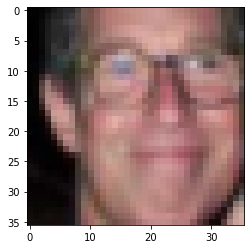

In [ ]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

s = keras.backend.get_session()

print(tf.__version__)

Using TensorFlow backend.


1.15.2


In [ ]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
#generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
#generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2DTranspose(3,kernel_size=3,activation=None))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [ ]:
# discriminator = Sequential()

# discriminator.add(L.InputLayer(IMG_SHAPE))

# <build discriminator body>

# discriminator.add(L.Flatten())
# discriminator.add(L.Dense(256,activation='tanh'))
# discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(8, (3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.Conv2D(16, (3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.MaxPool2D())
discriminator.add(L.Conv2D(32, (3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.Conv2D(64, (3, 3)))
discriminator.add(L.LeakyReLU(0.1))
discriminator.add(L.MaxPool2D())
discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [ ]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)#<gen(noise)>

logp_gen = discriminator(generated_data)#<log P(real | gen(noise))


In [ ]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1])#<generator loss>

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [ ]:
s.run(tf.global_variables_initializer())

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [ ]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

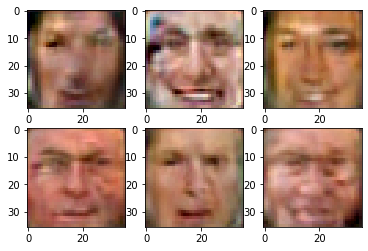

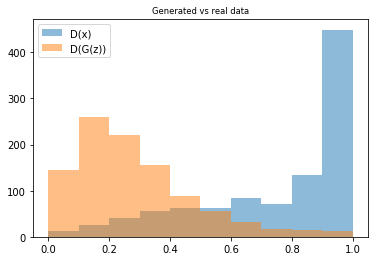

In [ ]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(15000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        

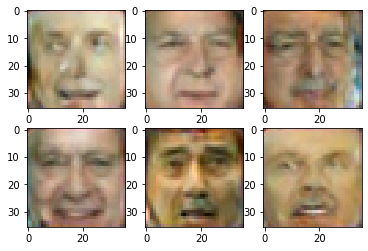

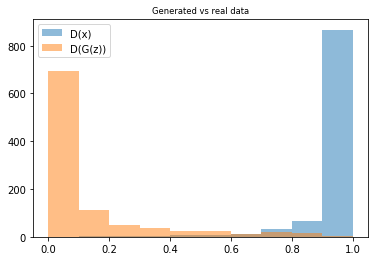

In [ ]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(30000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)

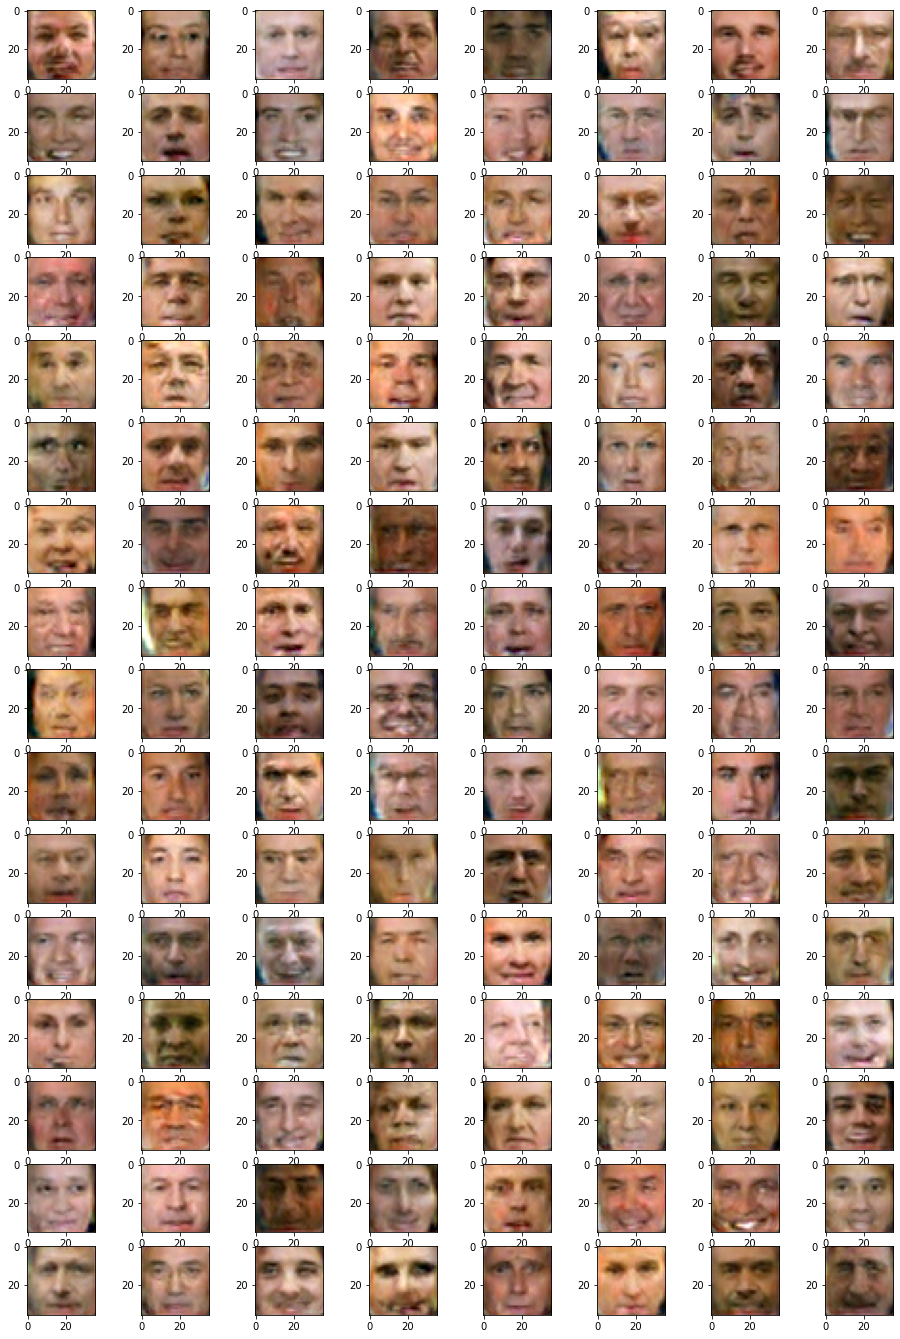

In [ ]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)